# Влияние погодных условий на прогнозирование количества аренд велосипедов в Лондоне
Автор: [Владимир Сизов](mailto:vladimirsizov@yandex.ru)

### Введение
В этом блокноте представлен анализ количества аренды велосипедов в Лондоне c 2015-01-04 по 2017-01-03. 

Мы будем исследовать:
- какие факторы погодных условий и на сколько влияют на изменения количества аренды велосипедистов.
- как **сезонность**, **праздничные дни** и **погодные условия** (влажность, температура, скорость ветра) влияют на точность предсказаний количества аренд велосипедов.

Мы используем метод линейной регрессии для определения размера влияния, а также библиотеку fbprophet для предсказания количества аренды велосипедов.
Fbprophet реализует обобщенную аддитивную модель и, моделирует временной ряд как сумму различных компонентов (нелинейный тренд, периодические компоненты и праздники или особые события) и позволяет включать регрессоры.

<hr>

Сначала мы исследуем некоторые характеристики почасовых и недельных циклов, построим модель линейной регрессии, а также построим модель сначала без, а затем с погодными регрессорами.

In [23]:
# ипортируем библиотеки

# работы с массивами данных и математическими преобразованиями
import pandas as pd
import numpy as np
from patsy import dmatrices

# тесты
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# предсказание и календарь праздничных событий
from fbprophet import Prophet
from fbprophet.make_holidays import make_holidays_df

# отображение значений дней недели для графика
from calendar import day_abbr, month_abbr

# отображение графиков
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (16,6)})

In [24]:
# мы будем работать с уже подготовленными данными
df = pd.read_csv('data_london.csv', parse_dates=['timestamp'])
df['month'] = df.timestamp.dt.month
df.head()

,timestamp,count,temperature,humidity,wind,month
0,2015-01-04 00:00:00,182,3.0,93.0,6.0,1
1,2015-01-04 01:00:00,138,3.0,93.0,5.0,1
2,2015-01-04 02:00:00,134,2.5,96.5,0.0,1
3,2015-01-04 03:00:00,72,2.0,100.0,0.0,1
4,2015-01-04 04:00:00,47,2.0,93.0,6.5,1


Описание данных:  
timestamp – дата и время    
count – количество аренд велосипедов  
temperature – температура, С   
humidity – влажность (%)  
wind – скорость ветра, км/ч

<hr>

# 1. Разведочный анализ данных
Мы хотим посмотреть на наши данные повнимательнее, какие тенденции существуют и что можно сравнить.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    17414 non-null  datetime64[ns]
 1   count        17414 non-null  int64         
 2   temperature  17414 non-null  float64       
 3   humidity     17414 non-null  float64       
 4   wind         17414 non-null  float64       
 5   month        17414 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 816.4 KB


Посмотрим на количество велосипедистов в зависимости от дня недели и времени суток

In [26]:
# добавим некоторые колонки к данным
hour_week = df[['timestamp', 'count']].copy()
hour_week['hour'] = hour_week['timestamp'].dt.hour
hour_week['day_of_week'] = hour_week['timestamp'].dt.dayofweek
hour_week['week_day_type'] = hour_week['day_of_week'].apply(lambda x: 'weekend' if x>5 else 'weekday')

In [27]:
# сгруппируем данные для построения графика
hour_all_week = hour_week.copy().groupby(['day_of_week', 'hour']).mean().unstack()
hour_all_week.columns = hour_all_week.columns.droplevel(0)
hour_all_week

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,212.471154,119.663462,74.605769,49.240385,52.355769,112.221154,536.807692,1759.971429,3504.800000,1802.523810,...,1178.634615,1281.221154,1689.638095,3130.714286,2990.600000,1759.990476,1075.750000,698.067308,498.447619,312.219048
1,168.380952,101.952381,65.403846,42.355769,46.576923,119.000000,657.266667,2128.923810,4098.200000,2004.476190,...,1150.809524,1264.838095,1777.895238,3365.471154,3285.711538,1928.250000,1180.894231,826.339806,606.607843,378.213592
2,203.116505,116.815534,68.320388,45.922330,47.407767,115.796117,639.105769,2098.153846,4045.173077,2042.596154,...,1165.317308,1279.634615,1781.336538,3364.298077,3281.538462,1960.660194,1209.528846,849.076923,661.894231,434.673077
3,212.951923,126.269231,83.567308,53.817308,51.836538,117.615385,645.817308,2102.153846,4094.262136,2144.365385,...,1247.961538,1368.701923,1858.230769,3266.310680,3144.009709,1897.471154,1192.182692,846.990385,673.807692,497.407767
4,281.519608,176.382353,113.647059,75.485149,63.336634,115.613861,542.578431,1752.613861,3572.178218,1995.843137,...,1318.901961,1458.796117,1903.650485,3033.116505,2553.873786,1581.621359,1010.281553,724.922330,634.009804,555.509804
5,460.117647,355.735294,255.267327,180.178218,121.594059,93.108911,123.825243,248.834951,493.313725,873.184466,...,2096.961538,2154.076923,2049.192308,1845.913462,1558.048077,1261.728155,912.252427,656.038835,598.553398,566.514563
6,499.125000,410.259615,297.203883,214.192308,130.942308,101.278846,117.317308,177.875000,339.750000,702.423077,...,2139.171429,2141.400000,2030.066667,1814.295238,1600.171429,1172.961905,837.819048,588.619048,476.695238,335.666667


In [28]:
# график нагрузки в зависимости от дня недели и времени суток
def heatmap_hour_week(data):
    f, ax = plt.subplots()
    sns.heatmap(data, ax=ax, cmap='Reds', \
                vmin=data.min().min(), vmax=data.max().max(), \
                cbar_kws={'boundaries':np.arange(data.min().min(), data.max().max())})
    f.axes[1].set_ylabel('cyclists number')
    ax.set_title('Number of cyclists per day of week and hour of the day')
    ax.set_xlabel('hour of the day')
    ax.set_ylabel('day of the week')
    ax.set_yticklabels(day_abbr[0:7]);

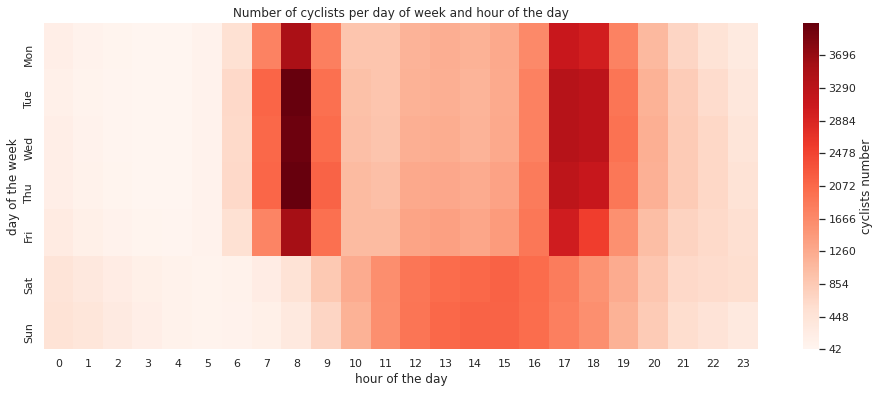

In [29]:
# тепловая карта количества арендованых велосипедов в зависимости от дня недели и времени суток
heatmap_hour_week(hour_all_week)

Посмотрим на распределение нагрузки отдельно по будним дням и выходным

In [30]:
# сгруппируем данные по будним дням и выходным
hour_weekday = hour_week[hour_week.week_day_type == 'weekday'].groupby('hour')['count'] \
    .agg(('min', 'mean', 'max')).round().reset_index(drop=True)
hour_weekend = hour_week[hour_week.week_day_type == 'weekend'].groupby('hour')['count'] \
    .agg(('min', 'mean', 'max')).round().reset_index(drop=True)
hour_weekday.head()

,min,mean,max
0,29,256.0,982
1,14,165.0,686
2,12,109.0,486
3,9,74.0,313
4,15,64.0,219


In [31]:
# график нагрузки в зависимости от дня недели и времени суток
def week_day_plot(hour_weekday, hour_weekend):
    f, ax = plt.subplots()
    ax.plot(hour_weekday['min'], color='steelblue', lw=0.3)
    ax.plot(hour_weekday['mean'], color='steelblue')
    ax.plot(hour_weekday['max'], color='steelblue', lw=0.3)
    ax.fill_between(hour_weekday.index, hour_weekday['min'], hour_weekday['max'], color='steelblue', alpha=0.1)
    ax.plot(hour_weekend['min'], color='coral', lw=0.3)
    ax.plot(hour_weekend['mean'], color='coral')
    ax.plot(hour_weekend['max'], color='coral', lw=0.3)
    ax.fill_between(hour_weekend.index, hour_weekend['min'], hour_weekend['max'], color='coral', alpha=0.1);
    ax.set_title('Number of cyclists per hour of weekday or weekend')
    ax.set_xlabel('hour of the day')
    ax.set_ylabel('cyclists');

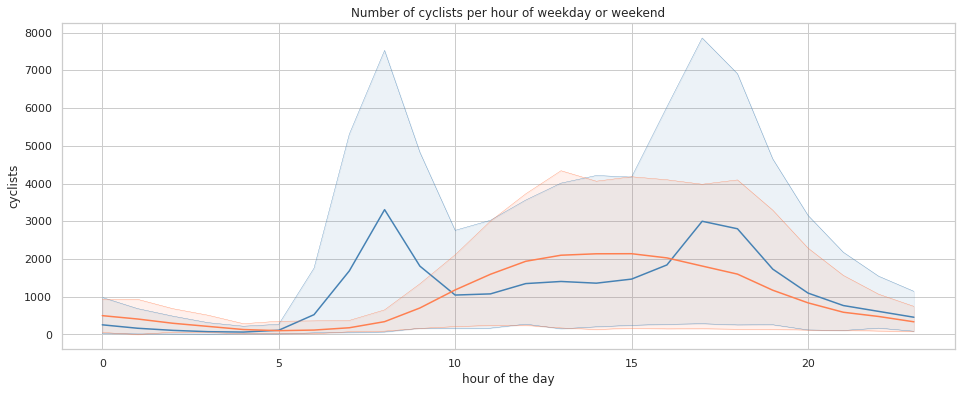

In [32]:
week_day_plot(hour_weekday, hour_weekend)

Распределение нагрузки по месяцам

In [33]:
trend_year = hour_week.copy()
trend_year['month'] = trend_year['timestamp'].dt.month
trend_year = trend_year.groupby('month')['count'] \
    .agg(('min', 'mean', 'max')).round().reset_index(drop=True)
trend_year.head()

,min,mean,max
0,10,785.0,4054
1,12,836.0,4051
2,0,921.0,4125
3,11,1113.0,4646
4,13,1275.0,5322


In [34]:
# график нагрузки в зависимости от месяца
def month_plot(trend_year):
    f, ax = plt.subplots()
    ax.plot(trend_year['min'], color='steelblue', lw=0.3)
    ax.plot(trend_year['mean'], color='steelblue')
    ax.plot(trend_year['max'], color='steelblue', lw=0.3)
    ax.fill_between(trend_year.index, trend_year['min'], trend_year['max'], color='steelblue', alpha=0.1)
    ax.set_title('Number of cyclists per month')
    ax.set_xlabel('month')
    ax.set_ylabel('cyclists');
    #ax.set_xticklabels(month_abbr[0:11]);

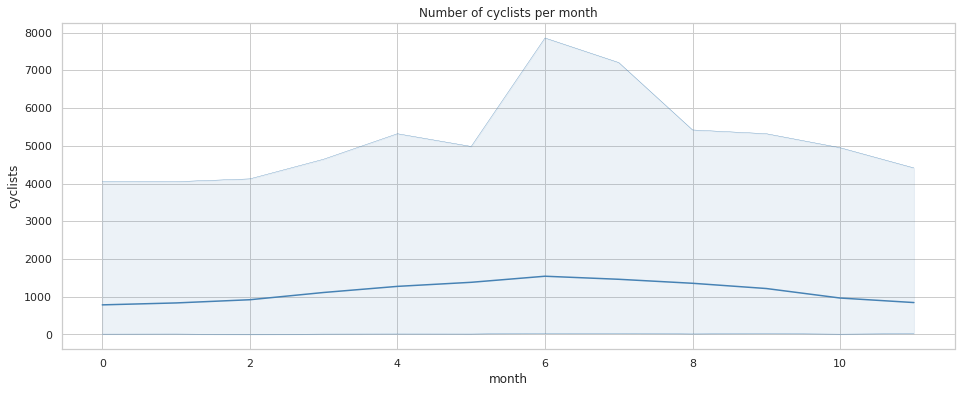

In [35]:
month_plot(trend_year)

Лобопытно посмотреть на корреляцию между количеством аренд велосипедов и показателями погодных условий

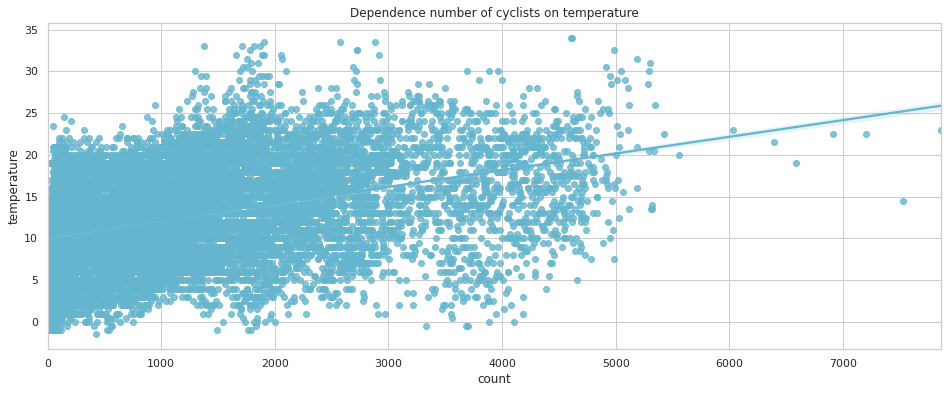

In [36]:
# отношение температуры на количество аренд велосипедов
sns.regplot(data=df, x='count', y='temperature', color='c').set(title='Dependence number of cyclists on temperature');

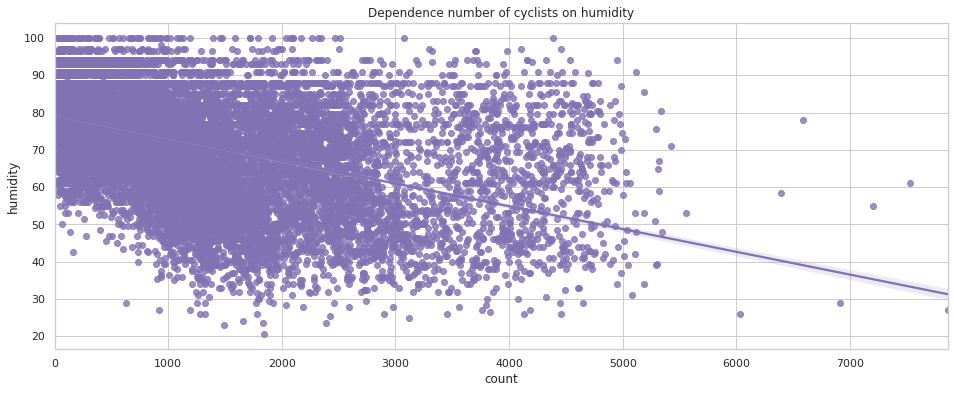

In [37]:
# отношение влажности на количество аренд велосипедов
sns.regplot(data=df, x='count', y='humidity', color='m').set(title='Dependence number of cyclists on humidity');

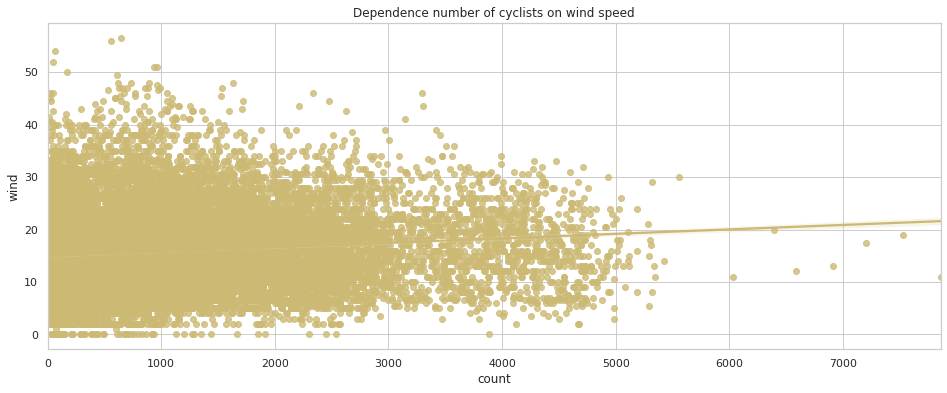

In [38]:
# отношение скорости ветра на количество аренд велосипедов
sns.regplot(data=df, x='count', y='wind', color='y').set(title='Dependence number of cyclists on wind speed');

<hr>

# 2. Регрессионный анализ
Оценим влияние погодных условий на количество аренд велосипедов

In [39]:
reg = df.copy()
reg.head()

,timestamp,count,temperature,humidity,wind,month
0,2015-01-04 00:00:00,182,3.0,93.0,6.0,1
1,2015-01-04 01:00:00,138,3.0,93.0,5.0,1
2,2015-01-04 02:00:00,134,2.5,96.5,0.0,1
3,2015-01-04 03:00:00,72,2.0,100.0,0.0,1
4,2015-01-04 04:00:00,47,2.0,93.0,6.5,1


In [40]:
# определяем переменные
y = reg['count']
# предикторы
x = reg[['temperature', 'humidity', 'wind']]

In [41]:
#добавляем константу
x = sm.add_constant(x)

In [42]:
# подбираем модель линейной регрессии 
model = sm.OLS(y, x).fit()

In [43]:
#смотрим сводку
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     1996.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:59:11   Log-Likelihood:            -1.4385e+05
No. Observations:               17414   AIC:                         2.877e+05
Df Residuals:                   17410   BIC:                         2.877e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2655.1744     56.882     46.678      

R-squared показывает что предикторы объясняют 25.6% дисперсии.  

pvalue<0.05 всех параметров, сообщает что все предикторы имеют статистически значимую связь с  количеством аренд велосипедов.

коэффициенты:  
temperature    44.3080  
humidity      -27.8624  
wind           -3.1022  

для каждой переменной-предиктора говорят нам о среднем ожидаемом изменении переменной отклика, предполагая, что другая переменная-предиктор остается постоянной.

расчётная формула:  
y = 2655 + 44.308 * temperature - 27.8624 * humidity - 3.1022 * wind

<hr>
Теперь посмотрим как это влияет на прогнозирование заказов

## Проверка модели

### Графики остатков
Проверяем, существует ли линейная зависимость между независимой переменной и зависимыми переменными, а также на гетероскедастичность остатков.  
В частности, проверим на отсутствие корреляции между последовательными остатками в данных временных рядов.

eval_env: 1


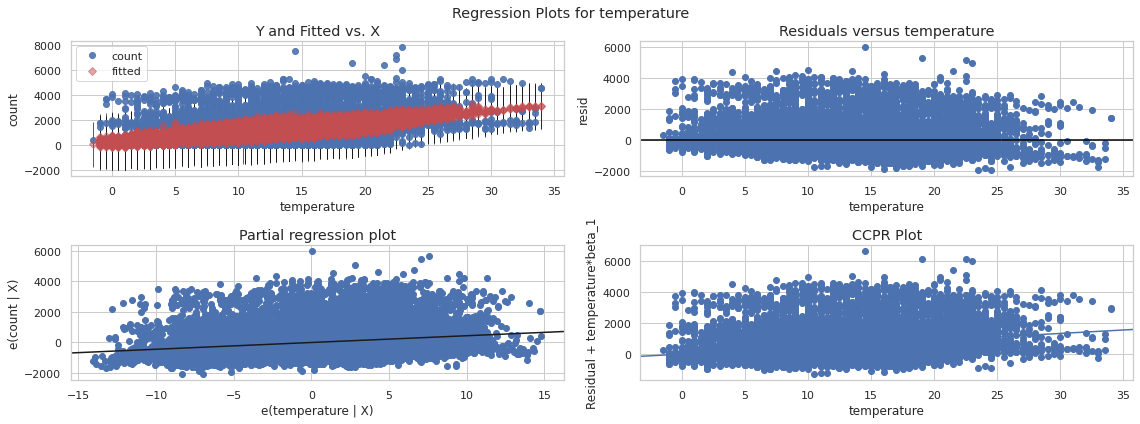

In [44]:
# температура temperature
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(model, 'temperature', fig=fig)

eval_env: 1


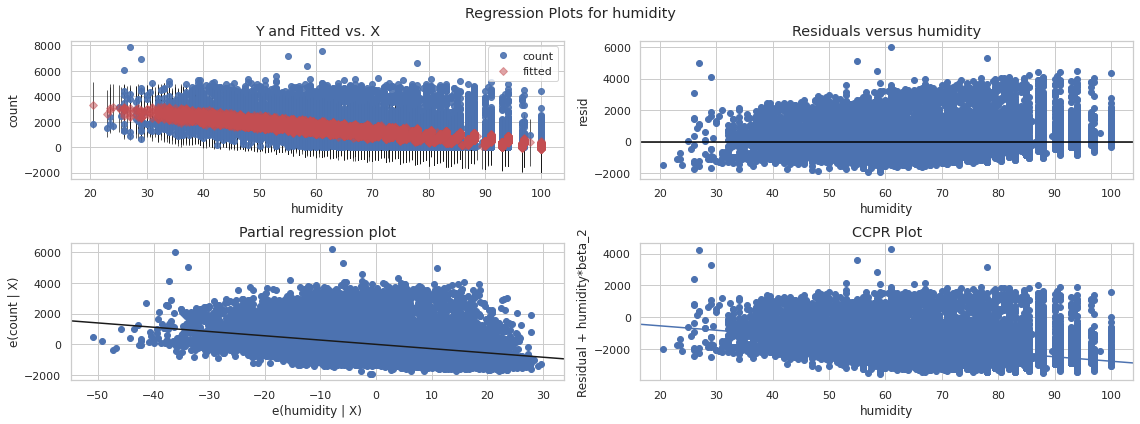

In [45]:
# влажность humidity
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(model, 'humidity', fig=fig)

eval_env: 1


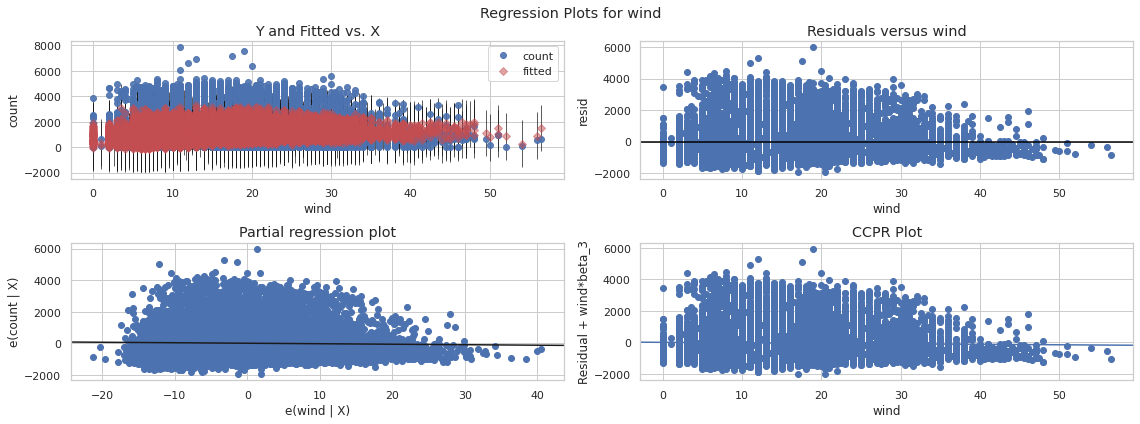

In [46]:
# сила ветра wind
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(model, 'wind', fig=fig)

### тест Дарбина-Ватсона
тест на независимость остатков

In [47]:
durbin_watson(model.resid)

0.5825512571617688

Сообщает что остатки не находятся в диапазоне 1.5-2.5, это значит остатки автокоррелированы, и это несколько ухудшает прогноз.

### тест Бреуша-Пагана
тест на гомоскедастичность остатков, наличие постоянной дисперсии

In [48]:
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(names, test)

[('Lagrange multiplier statistic', 133.28605846984422),
 ('p-value', 1.0589002070220034e-28),
 ('f-value', 44.76108039308085),
 ('f p-value', 8.320357017200937e-29)]

Так как pvalue<0.05, остатки гетероскедастичны

### тесты на Нормальность распределений
Проверим на нормальность распределений, что остатки модели нормально распределены.
### графики QQ-plot

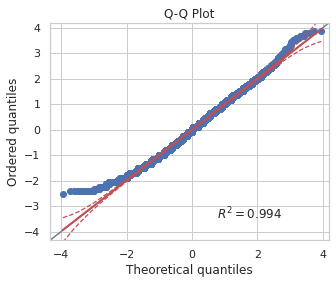

In [49]:
# температура temperature
pg.qqplot(df.temperature);

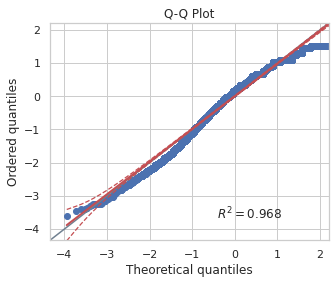

In [50]:
# влажность humidity
pg.qqplot(df.humidity);

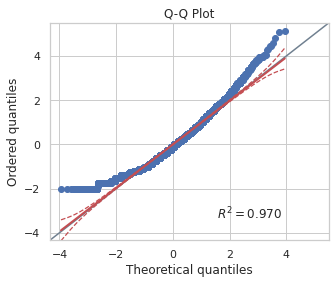

In [51]:
# сила ветра wind
pg.qqplot(df.wind);

### тест Харке-Бера
Проверяем на ассиметрию и эксцесс у нормального распределения

In [52]:
# температура temperature
stats.jarque_bera(df.temperature)

Jarque_beraResult(statistic=170.38719698941566, pvalue=0.0)

In [53]:
# влажность humidity
stats.jarque_bera(df.humidity)

Jarque_beraResult(statistic=999.5962464564715, pvalue=0.0)

In [54]:
# сила ветра wind
stats.jarque_bera(df.wind)

Jarque_beraResult(statistic=1444.914730501016, pvalue=0.0)

pvalue<0.05, значения имеют ассиметрию и эксцесс значительно отличающуюся от нормального распределения

### тест VIF
Проверяем на мультиколлинеарность (коэффециент инфляции дисперсии)

In [55]:
# определяем матрицу для модели линейной регрессии используя'count' в качестве зависимой переменной
y, X = dmatrices('count ~ temperature+humidity+wind+month', data=df, return_type='dataframe')

In [56]:
# рассчитать VIF для каждой независимой переменной
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [57]:
# VIF для каждой независимой переменной
vif

,VIF,variable
0,64.777609,Intercept
1,1.540669,temperature
2,1.454939,humidity
3,1.096394,wind
4,1.251261,month


1 - отсутствие корреляции  
1-5 - указывает на умеренную корреляцию между данной и другими независимыми переменными  
больше 5 потенциально сильная корреляця между данной независимой переменной и другими независимыми переменными в модели.   
<hr>

регрессионный анализ не очень хорошо описывает данные, попробуем использовать библиотеку fbprophet

# 3. Предсказание количества поездок с помощью fbprophet

Оценим влияние погодных условий на предсказание количества аренд велосипедов

Мы разделяем временные ряды на:
- обучающую выборку data_train (484 дня), с 2015-01-04 по 2016-04-30
- тестовую выборку data_test (248 дней), с 2016-05-01 по 2017-01-03

Модель будет установлена на обучающем наборе и оценена на тестовом наборе (вне выборочного прогноза), чтобы обеспечить достоверную оценку производительности модели.
Серая вертикальная полоса на рисунке ниже отмечает разделение между обучающим и тестовым наборами.
В оценке влияния регрессоров мы не будем использовать данные датафрейма колонки month, так как в сезонное влияние есть в настройках fbprophet

### Подготовка данных для предсказания количества аренды велосипедов

In [58]:
# группировка данных из формата "по часам" в формат "по дням"
def group_by_day(df):
    df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')
    df = df.groupby('timestamp').agg({'count': 'sum', \
                                      'temperature': 'mean', \
                                      'humidity': 'mean', \
                                      'wind': 'mean'}).reset_index()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [59]:
# сгруппируем данные по дням
df = group_by_day(df)

In [60]:
# нам необходимо переименовать некоторые столбцы потому что 
# fbprophet принимает данные timeseries через переменную ds, значения для предсказания в y
df.rename(columns={'timestamp': 'ds', 'count': 'y'}, inplace=True)
df.head()

,ds,y,temperature,humidity,wind
0,2015-01-04,9234,2.479167,94.270833,7.500000
1,2015-01-05,20372,8.041667,80.312500,8.854167
2,2015-01-06,20613,7.854167,78.895833,16.000000
3,2015-01-07,21064,7.456522,78.108696,19.760870
4,2015-01-08,15601,9.750000,79.312500,20.479167


In [61]:
# делим данные на для обучения и для проверки качества предсказания
cut_date = '2016-05-01'
cut_date = pd.to_datetime(cut_date).strftime('%Y-%m-%d %H:%M:%S')

In [62]:
# диапазон дат для data_train
data_train = df[df.ds < cut_date]
data_train.ds.min(), data_train.ds.max()

(Timestamp('2015-01-04 00:00:00'), Timestamp('2016-04-30 00:00:00'))

In [63]:
# диапазон дат для data_test
data_test = df[df.ds >= cut_date].reset_index(drop=True)
data_test.ds.min(), data_test.ds.max()

(Timestamp('2016-05-01 00:00:00'), Timestamp('2017-01-03 00:00:00'))

In [64]:
# собираем праздничные дни, чтобы отслеживать сезонную активность при построении модели
year_list = [i for i in range(df.ds.dt.year.min(), df.ds.dt.year.max()+1)]
df_holidays = make_holidays_df(year_list=year_list, country='UK')
year_list

[2015, 2016, 2017]

## Прогноз без регрессоров
Первым шагом в fbprophet является создание экземпляра модели.  
Здесь устанавливаем prior scales для каждого компонента вашего временного ряда.

Также количество рядов Фурье, которые будут использоваться для моделирования циклических компонентов.
Общее правило состоит в том, что большие априорные масштабы и большее количество рядов Фурье сделают модель более гибкой, но за счет потенциального обобщения модель может переобучиться, изучая шум (а не сигнал) в обучающих данных, что дает плохие результаты при применении к тестовым данным.

Установка этих гиперпараметров может быть больше искусством, чем наукой.

In [65]:
# настраиваем модель
m = Prophet(mcmc_samples=300, \
            holidays=df_holidays, \
            holidays_prior_scale=0.25, \
            changepoint_prior_scale=0.01, \
            seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [66]:
# тренируем модель на данных
m.fit(data_train)

In [67]:
# создаём датафрейм для регрессоров
futures = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [68]:
# предсказываем
forecast = m.predict(futures)

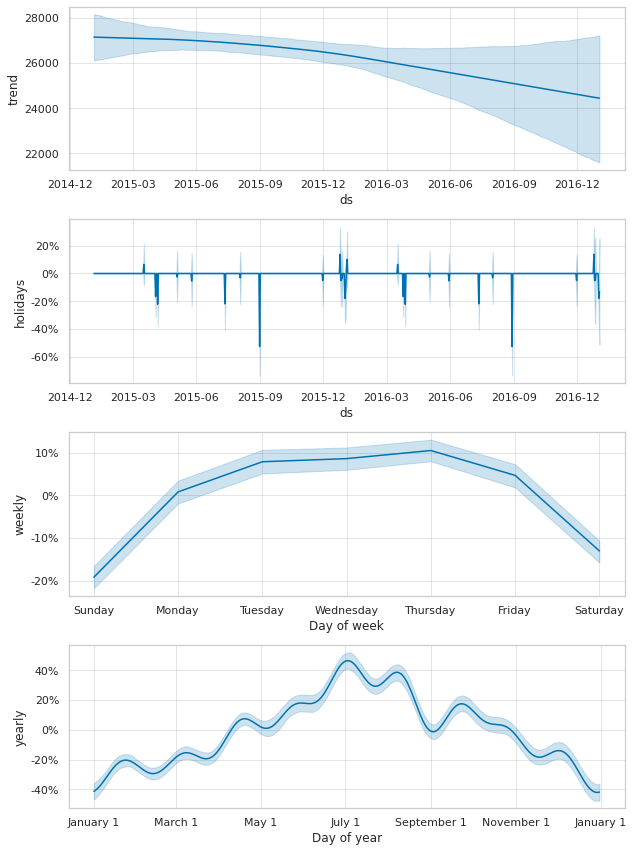

In [69]:
# графики с показателями точности предсказаний трендов, праздников, недельной и годовой сезональности
f = m.plot_components(forecast)

In [70]:
# сборка датафрейма данных результатов прогноза и фактических результатов
def make_verif(forecast, data_train, data_test): 
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    return forecast

In [71]:
# собираем датафрейм с данными результатов прогноза и фактических результатов
verif = make_verif(forecast, data_train, data_test)
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-04,2015-01-04,27148.247494,4818.862057,17529.534271,26115.520492,28167.144718,0.0,0.0,0.0,0.0,...,-0.217845,-0.166034,-0.395278,-0.445417,-0.339853,0.0,0.0,0.0,11197.396817,9234.0
2015-01-05,2015-01-05,27147.380938,10667.903945,23050.745543,26120.681279,28161.337108,0.0,0.0,0.0,0.0,...,-0.019388,0.034139,-0.385851,-0.435640,-0.332532,0.0,0.0,0.0,16883.062780,20372.0
2015-01-06,2015-01-06,27146.514381,12679.257926,25231.231147,26125.842065,28149.776752,0.0,0.0,0.0,0.0,...,0.050906,0.106298,-0.375291,-0.424122,-0.323726,0.0,0.0,0.0,19087.100455,20613.0
2015-01-07,2015-01-07,27145.647825,13132.630808,26431.440319,26131.002851,28144.549249,0.0,0.0,0.0,0.0,...,0.059509,0.111836,-0.363783,-0.411217,-0.313907,0.0,0.0,0.0,19598.637855,21064.0
2015-01-08,2015-01-08,27144.781269,14439.669107,26482.683530,26138.233227,28139.321746,0.0,0.0,0.0,0.0,...,0.079574,0.130188,-0.351520,-0.397618,-0.301409,0.0,0.0,0.0,20445.162256,15601.0


In [72]:
# построение графика результата прогноза
def plot_verif(verif, forecast_date):
    f, ax = plt.subplots()
    train = verif.loc[:str(forecast_date),:] #-1
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    test = verif.loc[str(forecast_date):,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.axvline(pd.to_datetime(forecast_date), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    return f

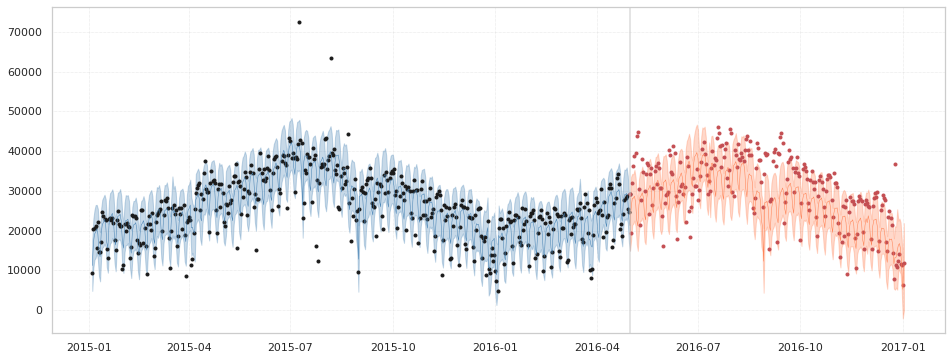

In [73]:
# построим графика результата прогноза
f = plot_verif(verif, cut_date)

In [74]:
# подсчет ошибок предсказания
def absolute_error(forecast):
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
    mape = np.mean(abs(cmp_df[-len(data_test):]['p']))
    mae = np.mean(abs(cmp_df[-len(data_test):]['e']))
    print('MAPE (средняя абсолютная ошибка в процентах) – ', mape,'%')
    print('MAE (средняя абсолютная ошибка) – ', mae)
    return [mape, mae]

In [75]:
# Смотрим на ошибки модели
ae_without_reg = absolute_error(forecast)

MAPE (средняя абсолютная ошибка в процентах) –  19.81030621701817 %
MAE (средняя абсолютная ошибка) –  5924.26806343792


## Прогноз с регрессорами
Для корректности сравнения, мы используем те же срезы данных что и для прогноза без регрессоров

In [76]:
# настраиваем модель
m = Prophet(mcmc_samples=300, \
            holidays=df_holidays, \
            holidays_prior_scale=0.25, \
            changepoint_prior_scale=0.01, \
            seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [77]:
# настраиваем регрессоры
m.add_regressor('temperature', prior_scale=0.5, mode='multiplicative')
m.add_regressor('humidity', prior_scale=0.5, mode='multiplicative')
m.add_regressor('wind', prior_scale=0.5, mode='multiplicative')

In [78]:
# тренируем модель на данных
m.fit(data_train)

In [79]:
# создаём датафрейм для регрессоров
futures = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [80]:
# собираем данные регрессоров
data_with_regressors = df.set_index('ds')
regressors = [data_with_regressors.temperature, data_with_regressors.humidity, data_with_regressors.wind]

In [81]:
# создание датафрейм с данными регрессоров
def add_regressor_to_future(futures, regressors): 
    futures = futures.copy()
    futures.index = pd.to_datetime(futures.ds)
    df_regressors = pd.concat(regressors, axis=1)
    futures = futures.merge(df_regressors, left_index=True, right_index=True)
    futures = futures.reset_index(drop=True)
    return futures

In [82]:
# собираем датафрейм с регрессорами
futures = add_regressor_to_future(futures, regressors)
futures.head()

,ds,temperature,humidity,wind
0,2015-01-04,2.479167,94.270833,7.500000
1,2015-01-05,8.041667,80.312500,8.854167
2,2015-01-06,7.854167,78.895833,16.000000
3,2015-01-07,7.456522,78.108696,19.760870
4,2015-01-08,9.750000,79.312500,20.479167


In [83]:
# предсказываем
forecast = m.predict(futures)

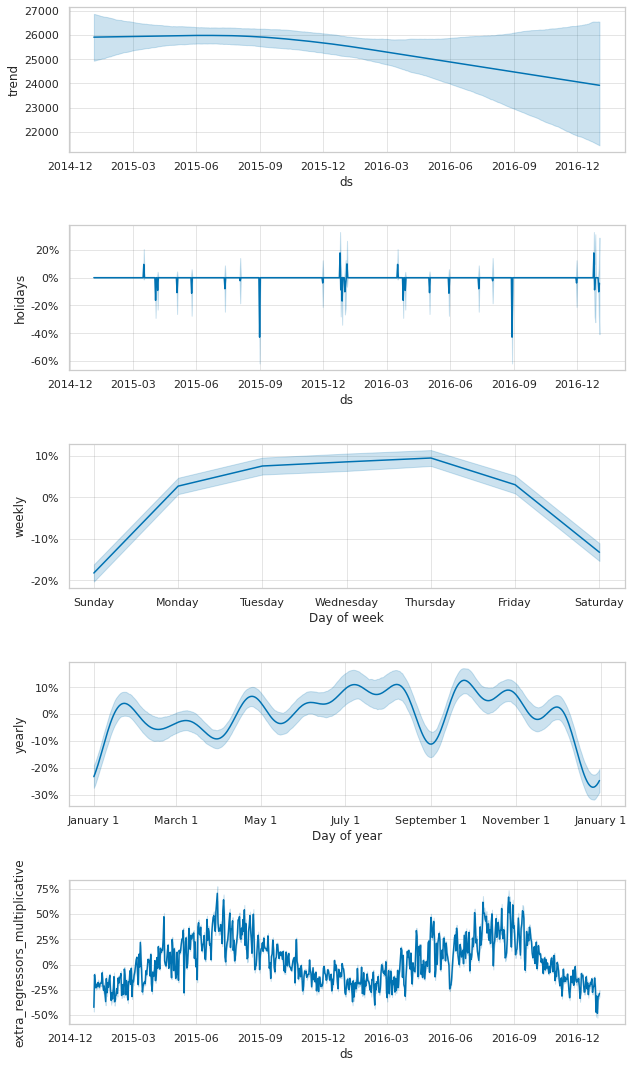

In [84]:
# графики с показателями точности предсказаний трендов, праздников, недельной и годовой сезональности
f = m.plot_components(forecast)

In [85]:
# собираем датафрейм с данными результатов прогноза и фактических результатов
verif = make_verif(forecast, data_train, data_test)
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,wind_lower,wind_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-04,2015-01-04,25911.895948,175.477533,9803.030810,24939.123838,26872.383981,0.0,0.0,0.0,0.0,...,0.107805,0.136460,-0.196687,-0.237444,-0.156524,0.0,0.0,0.0,5115.945100,9234
2015-01-05,2015-01-05,25912.399202,14452.936843,24732.503055,24942.307486,26867.002472,0.0,0.0,0.0,0.0,...,0.092097,0.116577,-0.180007,-0.220836,-0.139174,0.0,0.0,0.0,19313.467539,20372
2015-01-06,2015-01-06,25912.902456,14159.568750,23729.193008,24952.375926,26859.020581,0.0,0.0,0.0,0.0,...,0.009209,0.011657,-0.162524,-0.203550,-0.120821,0.0,0.0,0.0,18960.245408,20613
2015-01-07,2015-01-07,25913.405709,13500.412932,23202.721040,24960.834944,26850.841554,0.0,0.0,0.0,0.0,...,-0.043563,-0.034416,-0.144512,-0.186716,-0.102755,0.0,0.0,0.0,18408.395925,21064
2015-01-08,2015-01-08,25913.908963,15086.538031,24694.855199,24967.861779,26842.506102,0.0,0.0,0.0,0.0,...,-0.054110,-0.042747,-0.126248,-0.169830,-0.083901,0.0,0.0,0.0,20033.255850,15601


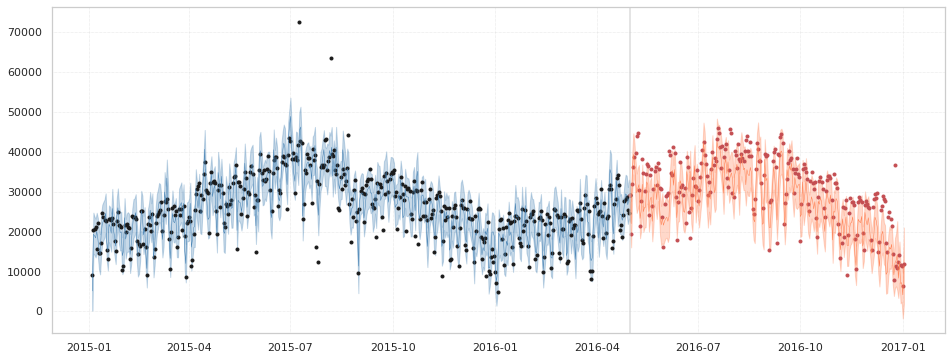

In [86]:
# построим графика результата прогноза
f = plot_verif(verif, cut_date)

In [87]:
# Смотрим на ошибки модели
ae_with_reg = absolute_error(forecast)

MAPE (средняя абсолютная ошибка в процентах) –  15.800943367028626 %
MAE (средняя абсолютная ошибка) –  4551.333699199046


In [88]:
# точность прогноза с регрессоров при сравнении с прогнозом без
print('Точность прогноза с использованием регрессоров при сравнении без, в', \
      round(ae_without_reg[0] / ae_with_reg[0], 2), 'раза.')

Точность прогноза с использованием регрессоров при сравнении без, в 1.25 раза.
